In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman


In [20]:
df_imagenet = pd.read_csv('./final_results/cifar10_sss.csv')
# df_cifar10 = pd.read_csv('./final_results/cifar10_results.csv')
# df_cifar100 = pd.read_csv('./final_results/cifar100_results.csv')

In [21]:
def get_ece_15_bins(ece_str):
    ece_data = eval(ece_str)
    for ece_entry in ece_data:
        if ece_entry['n_bins'] == 15:
            return ece_entry['result']
    return None

In [28]:
def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None

In [30]:
metrics_to_extract = [
    'ece', 'ece_em', 'cwECE', 'cwECE_em'
]
# , 'KSCE', 'KDECE', 'MMCE'
for metric in metrics_to_extract:
    for dataset, df in [('imagenet', df_imagenet)]:
        # , ('cifar10', df_cifar10), ('cifar100', df_cifar100)
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))

In [18]:
merged_df = df_imagenet[['config'] + [f"{metric}_imagenet" for metric in metrics_to_extract]].merge(
    df_cifar10[['config'] + [f"{metric}_cifar10" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_cifar100" for metric in metrics_to_extract]], on='config', how='outer'
)

In [15]:
merged_df = merged_df.fillna(0)

In [33]:
df.columns

Index(['config', 'info', 'dataset', 'arch', 'ece', 'ece_em', 'cwECE',
       'cwECE_em', 'timestamp', 'ece_imagenet', 'ece_em_imagenet',
       'cwECE_imagenet', 'cwECE_em_imagenet'],
      dtype='object')

In [34]:
plot_df =df[['ece_imagenet', 'ece_em_imagenet',
       'cwECE_imagenet', 'cwECE_em_imagenet']]

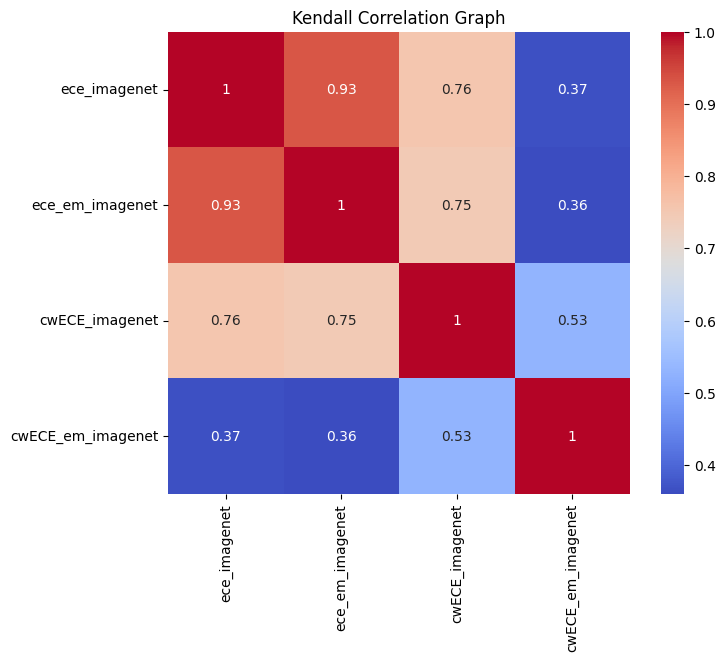

In [35]:


# Calculate the Kendall correlation matrix for the specified columns
correlation_matrix = plot_df.corr(method='kendall')

# Draw the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Kendall Correlation Graph')

# Show the plot
plt.show()

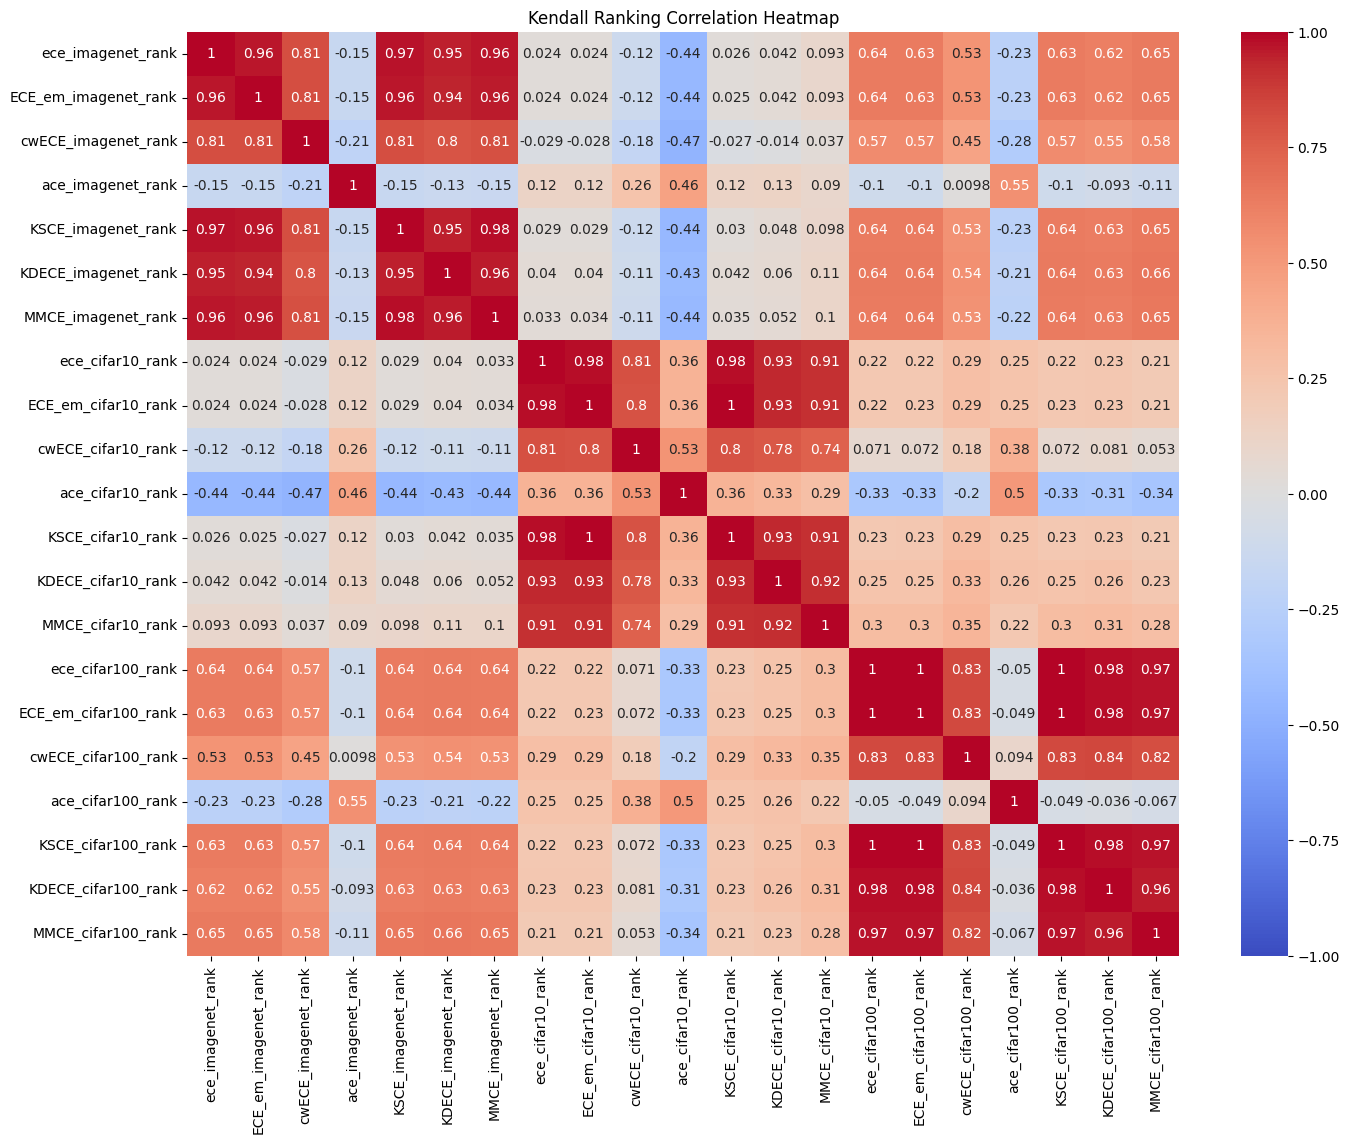

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['imagenet', 'cifar10', 'cifar100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}_rank"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the Kendall ranking correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}_rank" for dataset in ['imagenet', 'cifar10', 'cifar100'] for metric in metrics_to_extract]
corr_matrix = pd.DataFrame(index=rank_columns, columns=rank_columns)

for col1 in rank_columns:
    for col2 in rank_columns:
        corr, _ = kendalltau(merged_df[col1], merged_df[col2])
        corr_matrix.loc[col1, col2] = corr

# Create a correlation heatmap using seaborn
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Kendall Ranking Correlation Heatmap")
# plt.savefig("fig/Kendall_Ranking_Correlation_Heatmap_of_Metric_Rankings.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>